In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3097776588_312932e438.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/1319634306_816f21677f.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8kimagescaptions/flickr8k/images/2949337912_beba55698

# Installs and Imports

In [42]:
!pip install --upgrade nltk

In [43]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [114]:
import os
import re
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import transforms
from torchvision.models import resnet50,ResNet50_Weights
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import random
from textwrap import wrap
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as T
from torchvision import models
import torch.nn.functional as F

In [45]:
# to make sure the results are reproducible
torch.manual_seed(0)
random.seed(42)


# Dataset

In [198]:
df=pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")


In [199]:
def read_image(path,img_size=224):
      transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()])
      img = Image.open(path).convert('RGB')
      img = transform(img)
      return img.permute(1, 2, 0).numpy()

In [200]:
def display_image(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(5):  # Display 5 images
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image_path = f"/kaggle/input/flickr8kimagescaptions/flickr8k/images/{temp_df.image[i]}"
        image = read_image(image_path)
        plt.imshow(image)
        
        # Display the caption
        caption = "\n".join(wrap(temp_df.caption[i], 20))  # Wrap text for better display
        plt.title(caption)
        plt.axis("off")  # Turn off axis
    
    plt.show()

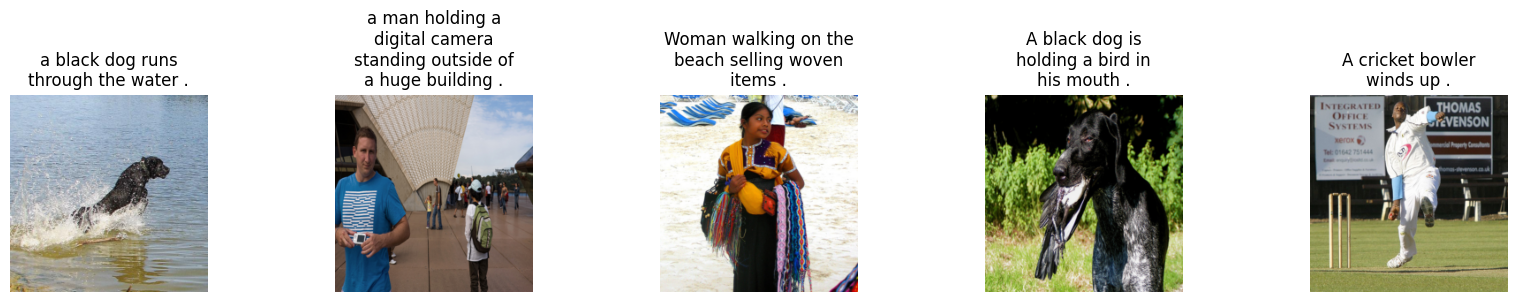

In [201]:
display_image(df.sample(5))

# Data Preprocessing

In [202]:
image_captions = defaultdict(list)
for idx, row in df.iterrows():
    image_captions[row['image']].append(row['caption'])


In [203]:
def tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    # Use regular expressions to extract words (alphanumeric characters)
    tokens = re.findall(r'\w+', text)
    return tokens

In [204]:
all_captions = []
for captions in image_captions.values():
    all_captions.extend(captions)

In [205]:
all_words = []
for caption in all_captions:
    tokens = tokenize(caption)
    all_words.extend(tokens)

In [206]:
all_words[0:10]

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']

In [207]:
all_captions[0:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [208]:
word_counts = Counter(all_words)
word_counts["girl"]

3328

In [209]:
special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
# Create mappings from words to indices and vice versa
word2idx = {token: idx for idx, token in enumerate(special_tokens)}
idx2word = {idx: token for idx, token in enumerate(special_tokens)}

In [210]:
word2idx

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

In [211]:
idx2word

{0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}

In [212]:
vocab_size = 10000 # we have set it as the max limit inluding the special tokens
most_common = word_counts.most_common(vocab_size - len(special_tokens))

In [213]:
start_token_id=1
end_token_id=2

In [214]:
most_common[0:10]

[('a', 62992),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7274),
 ('of', 6723)]

In [215]:
len(most_common)

8488

In [216]:
# we are starting after the length of start tokens
for idx, (word, _) in enumerate(most_common, start=len(special_tokens)):
    word2idx[word] = idx
    idx2word[idx] = word

In [217]:
word2idx["a"]

4

In [218]:
captions_seqs = {}
max_length = 0  # Keep track of the maximum caption length
for img_name, captions in image_captions.items():
    seqs = []
    for caption in captions:
        # Tokenize the caption and add <start> and <end> tokens
        tokens = ['<start>'] + tokenize(caption) + ['<end>']
        # Convert tokens to indices, use <unk> index if word not in vocabulary
        seq = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
        seqs.append(seq)
        # Update the maximum caption length
        max_length = max(max_length, len(seq))
    captions_seqs[img_name] = seqs

In [219]:
# so now we have a dictionary with image as key and indices of words in captions as keys so the values is a list of lists
captions_seqs["1000268201_693b08cb0e.jpg"]

[[1, 4, 44, 5, 4, 91, 173, 8, 120, 52, 4, 394, 13, 395, 5, 29, 5156, 671, 2],
 [1, 4, 20, 317, 65, 4, 197, 118, 2],
 [1, 4, 41, 20, 120, 65, 4, 197, 2438, 2],
 [1, 4, 41, 20, 120, 6, 395, 21, 61, 2438, 2],
 [1, 4, 41, 20, 5, 4, 91, 173, 317, 65, 4, 197, 2982, 2]]

# Image Transformation for Preprocessing

In [246]:
transform = T.Compose([
    T.Resize((224, 224)),  # VGG16 expects 224x224 input size
    T.ToTensor(),  # Convert PIL image to tensor
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

# Dataloader setup

In [247]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, image_ids, captions_seqs, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            image_ids (list): List of image filenames.
            captions_seqs (dict): Dictionary mapping image filenames to sequences of word indices.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.captions = []
        # Prepare the list of image and caption pairs
        for img_id in image_ids:
            captions = captions_seqs[img_id]
            for caption_seq in captions:
                self.images.append(img_id)
                self.captions.append(caption_seq)
    def __len__(self):
        # Return the total number of samples
        return len(self.images)
    def __getitem__(self, idx):
        # Get the image filename and caption sequence at the given index
        img_id = self.images[idx]
        caption_seq = self.captions[idx]
        # Load the image from the directory
        img_path = os.path.join(self.image_dir, img_id)
        image = Image.open(img_path).convert('RGB')

        # Apply the transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert the caption sequence to a tensor
        caption_seq = torch.tensor(caption_seq)
        return image, caption_seq


In [248]:
def collate_fn(data):
    """
    Creates mini-batch tensors from the list of tuples (image, caption).
    We sort the captions by length to use pack_padded_sequence.
    """
    # Sort data by caption length in descending order
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Stack images into a tensor of shape (batch_size, 3, H, W)
    images = torch.stack(images, 0)
    # Get the lengths of each caption
    lengths = [len(cap) for cap in captions]
    # Create a tensor to hold the padded captions
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        # Copy the caption into the targets tensor
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [249]:
image_dir = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'
image_names = list(image_captions.keys())

In [250]:
train_images, temp_images = train_test_split(image_names, test_size=0.3, random_state=22)

In [251]:

val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=12)


In [252]:
train_dataset = Flickr8kDataset(image_dir, train_images, captions_seqs, transform)
val_dataset   = Flickr8kDataset(image_dir, val_images, captions_seqs, transform)
test_dataset  = Flickr8kDataset(image_dir, test_images, captions_seqs, transform)

In [253]:
batch_size = 32  # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Model

## Encoder

In [254]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        
        # Load the pretrained VGG16 model
        vgg = models.vgg16(pretrained=True)
        
        # Extract layers up to the 4th convolutional block (before max pooling)
        self.features = nn.Sequential(*list(vgg.features.children())[:23])  # Layer index 23 is before the 4th max pool

    def forward(self, images):
        """
        Forward pass for the encoder.

        Args:
            images (torch.Tensor): Batch of input images of shape (batch_size, 3, height, width).

        Returns:
            features (torch.Tensor): Encoded image features of shape (batch_size, 196, 512).
        """
        # Extract convolutional features
        features = self.features(images)  # Shape: (batch_size, 512, 14, 14)

        # Reshape features to (batch_size, 196, 512)
        batch_size, channels, height, width = features.shape
        features = features.permute(0, 2, 3, 1).view(batch_size, -1, channels)  # Shape: (batch_size, 196, 512)

        return features

## Bahdanau Attention

In [255]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,features_dim)
        
        return alpha,attention_weights
        

## Decoder

In [256]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        # captions which are embedded 
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        # the average of the anotations are sent via a fully connected neural network for each cell and hidden
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        # captions will be of the form (batch_size,len_of_captions)
        # features or annotations will be of the form (num_of_features,feature_dim)
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0) 
        num_features = features.size(1) 
         
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device) 
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device) 
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    def generate_caption(self,features,max_len=20):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(word2idx['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if idx2word[predicted_word_idx.item()] == "<end>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [idx2word[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

## Encoder-Decoder Model

In [257]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Hyperparameters

In [258]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
epochs=10
# Hyperparameters
embed_size=256
attention_dim=256
encoder_dim=512
decoder_dim=512
learning_rate = 3e-4

Using device: cuda


In [259]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

## Loss Criteria and Optimizers

In [260]:
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [261]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training

In [262]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Epoch: 1 Training batch: 100 loss: 4.91076
Epoch: 1 Training batch: 200 loss: 4.40286
Epoch: 1 Training batch: 300 loss: 4.30305
Epoch: 1 Training batch: 400 loss: 4.06260
Epoch: 1 Training batch: 500 loss: 3.97593
Epoch: 1 Training batch: 600 loss: 3.87404
Epoch: 1 Training batch: 700 loss: 3.85325
Epoch: 1 Training batch: 800 loss: 4.05092
Epoch 1:
Average Training Loss: 4.35112
Validation Loss: 3.77189
BLEU Score: 0.02625


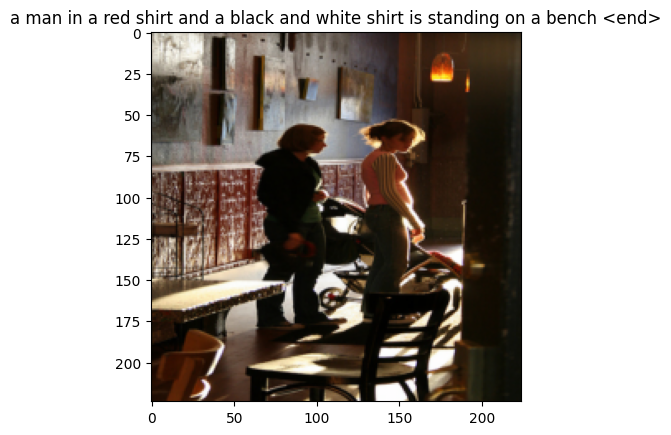

Epoch: 2 Training batch: 100 loss: 3.53732
Epoch: 2 Training batch: 200 loss: 3.90452
Epoch: 2 Training batch: 300 loss: 3.48800
Epoch: 2 Training batch: 400 loss: 3.78675
Epoch: 2 Training batch: 500 loss: 3.65597
Epoch: 2 Training batch: 600 loss: 3.54182
Epoch: 2 Training batch: 700 loss: 3.37624
Epoch: 2 Training batch: 800 loss: 3.46402
Epoch 2:
Average Training Loss: 3.52450
Validation Loss: 3.45337
BLEU Score: 0.03080


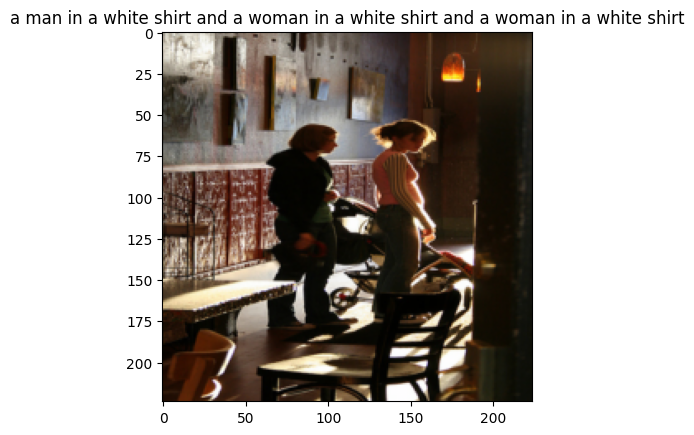

Epoch: 3 Training batch: 100 loss: 3.25131
Epoch: 3 Training batch: 200 loss: 3.34895
Epoch: 3 Training batch: 300 loss: 3.08610
Epoch: 3 Training batch: 400 loss: 3.35834
Epoch: 3 Training batch: 500 loss: 3.05105
Epoch: 3 Training batch: 600 loss: 3.18950
Epoch: 3 Training batch: 700 loss: 3.13209
Epoch: 3 Training batch: 800 loss: 3.16770
Epoch 3:
Average Training Loss: 3.20518
Validation Loss: 3.29905
BLEU Score: 0.04371


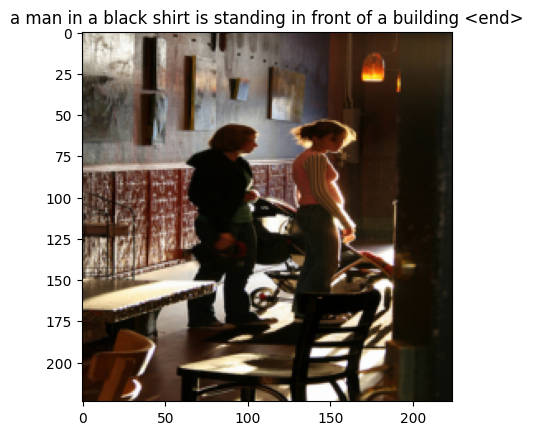

Epoch: 4 Training batch: 100 loss: 2.97968
Epoch: 4 Training batch: 200 loss: 3.01494
Epoch: 4 Training batch: 300 loss: 2.99226
Epoch: 4 Training batch: 400 loss: 2.86991
Epoch: 4 Training batch: 500 loss: 2.81395
Epoch: 4 Training batch: 600 loss: 2.64458
Epoch: 4 Training batch: 700 loss: 3.14087
Epoch: 4 Training batch: 800 loss: 3.05940
Epoch 4:
Average Training Loss: 2.97207
Validation Loss: 3.22038
BLEU Score: 0.04161


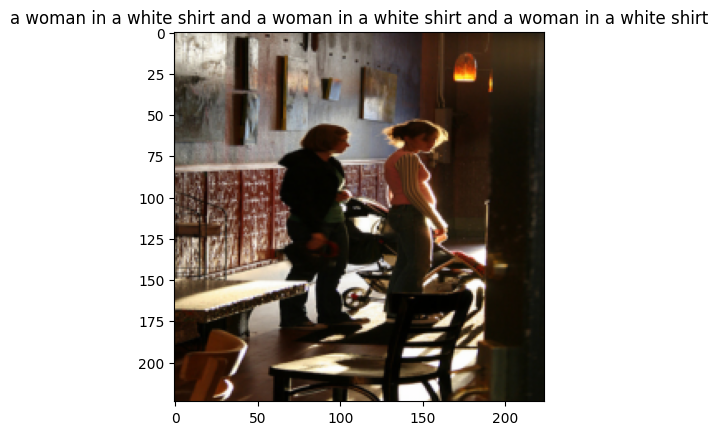

Epoch: 5 Training batch: 100 loss: 2.91195
Epoch: 5 Training batch: 200 loss: 2.66448
Epoch: 5 Training batch: 300 loss: 2.68627
Epoch: 5 Training batch: 400 loss: 2.87512
Epoch: 5 Training batch: 500 loss: 2.60958
Epoch: 5 Training batch: 600 loss: 2.60075
Epoch: 5 Training batch: 700 loss: 2.86388
Epoch: 5 Training batch: 800 loss: 2.82759
Epoch 5:
Average Training Loss: 2.78547
Validation Loss: 3.18095
BLEU Score: 0.04283


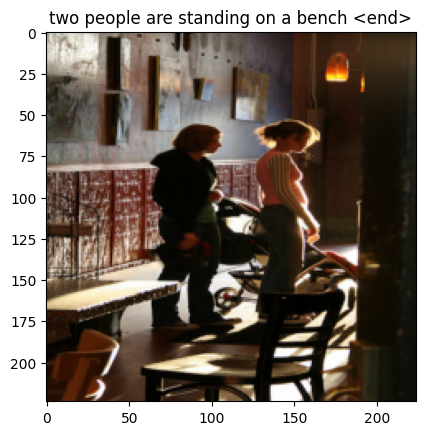

Epoch: 6 Training batch: 100 loss: 2.72820
Epoch: 6 Training batch: 200 loss: 2.57449
Epoch: 6 Training batch: 300 loss: 2.68934
Epoch: 6 Training batch: 400 loss: 2.56201
Epoch: 6 Training batch: 500 loss: 2.37144
Epoch: 6 Training batch: 600 loss: 2.48006
Epoch: 6 Training batch: 700 loss: 2.85291
Epoch: 6 Training batch: 800 loss: 2.54371
Epoch 6:
Average Training Loss: 2.62490
Validation Loss: 3.15212
BLEU Score: 0.04858


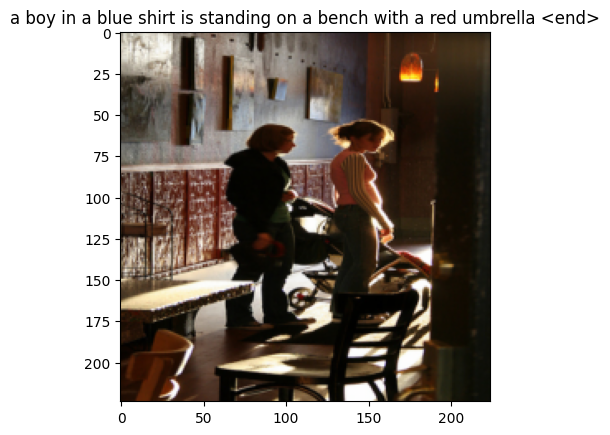

Epoch: 7 Training batch: 100 loss: 2.61236
Epoch: 7 Training batch: 200 loss: 2.55082
Epoch: 7 Training batch: 300 loss: 2.34715
Epoch: 7 Training batch: 400 loss: 2.34292
Epoch: 7 Training batch: 500 loss: 2.28724
Epoch: 7 Training batch: 600 loss: 2.41055
Epoch: 7 Training batch: 700 loss: 2.53957
Epoch: 7 Training batch: 800 loss: 2.68119
Epoch 7:
Average Training Loss: 2.48141
Validation Loss: 3.14772
BLEU Score: 0.05266


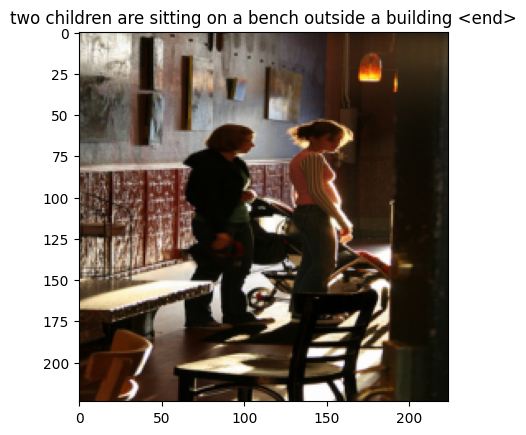

Epoch: 8 Training batch: 100 loss: 2.29639
Epoch: 8 Training batch: 200 loss: 2.29687
Epoch: 8 Training batch: 300 loss: 2.37893
Epoch: 8 Training batch: 400 loss: 2.56825
Epoch: 8 Training batch: 500 loss: 2.48710
Epoch: 8 Training batch: 600 loss: 2.27230
Epoch: 8 Training batch: 700 loss: 2.49265
Epoch: 8 Training batch: 800 loss: 2.28831
Epoch 8:
Average Training Loss: 2.34884
Validation Loss: 3.15433
BLEU Score: 0.05278


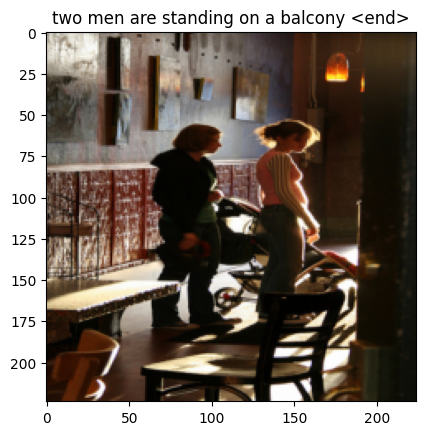

Epoch: 9 Training batch: 100 loss: 2.23200
Epoch: 9 Training batch: 200 loss: 2.20276
Epoch: 9 Training batch: 300 loss: 2.28237
Epoch: 9 Training batch: 400 loss: 2.36152
Epoch: 9 Training batch: 500 loss: 2.19935
Epoch: 9 Training batch: 600 loss: 2.22281
Epoch: 9 Training batch: 700 loss: 2.26377
Epoch: 9 Training batch: 800 loss: 2.03206
Epoch 9:
Average Training Loss: 2.22776
Validation Loss: 3.16885
BLEU Score: 0.04851


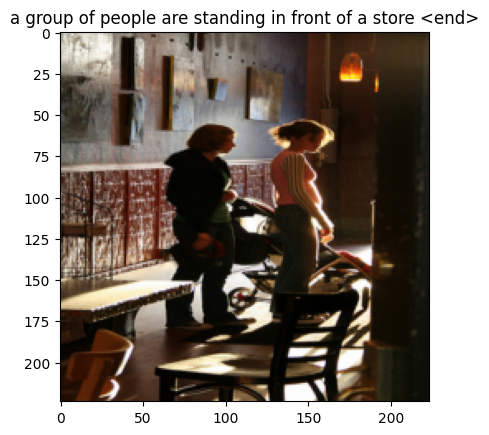

Epoch: 10 Training batch: 100 loss: 2.05021
Epoch: 10 Training batch: 200 loss: 1.96011
Epoch: 10 Training batch: 300 loss: 2.42953
Epoch: 10 Training batch: 400 loss: 1.89085
Epoch: 10 Training batch: 500 loss: 2.05456
Epoch: 10 Training batch: 600 loss: 2.27342
Epoch: 10 Training batch: 700 loss: 2.39403
Epoch: 10 Training batch: 800 loss: 2.14608
Epoch 10:
Average Training Loss: 2.11407
Validation Loss: 3.19972
BLEU Score: 0.05042


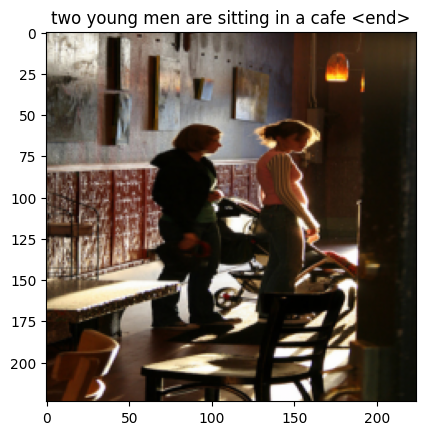

In [263]:
num_epochs = 10
print_every = 100
patience = 3
best_bleu = 0
patience_counter = 0
train_losses = []
val_losses = []
val_bleus = []

# Keep track of best model
best_model_state = None

for epoch in range(1, num_epochs+1):
    # Training phase
    model.train()
    epoch_train_loss = 0
    batch_count = 0
    
    for idx, (image, captions,_) in enumerate(train_loader):
        image, captions = image.to(device), captions.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Feed forward
        outputs, attentions = model(image, captions)
        
        # Calculate the batch loss
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        epoch_train_loss += loss.item()
        batch_count += 1
        
        if (idx+1) % print_every == 0:
            print(f"Epoch: {epoch} Training batch: {idx+1} loss: {loss.item():.5f}")
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / batch_count
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    batch_count = 0
    actual_captions = []
    predicted_captions = []
    
    with torch.no_grad():
        for val_images, val_captions,_ in val_loader:
            val_images = val_images.to(device)
            val_captions = val_captions.to(device)
            
            # Get model predictions
            outputs, _ = model(val_images, val_captions)
            targets = val_captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            
            val_loss += loss.item()
            batch_count += 1
            
            # Generate captions for BLEU score calculation
            features = model.module.encoder(val_images) if hasattr(model, 'module') else model.encoder(val_images)
            for i in range(val_images.size(0)):
                # Get actual caption (excluding start and end tokens)
                current_caption = val_captions[i].cpu().numpy().tolist()
                actual = [[idx2word[word] for word in current_caption if word != word2idx['<start>'] 
                          and word != word2idx['<end>'] and word != word2idx['<pad>']]]
                actual_captions.append(actual)
                
                # Generate predicted caption
                if hasattr(model, 'module'):
                    caps, _ = model.module.decoder.generate_caption(features[i:i+1])
                else:
                    caps, _ = model.decoder.generate_caption(features[i:i+1])
                predicted_captions.append(caps[:-1])  # exclude end token
    
    # Calculate average validation loss and BLEU score
    avg_val_loss = val_loss / batch_count
    val_losses.append(avg_val_loss)
    smoothie = SmoothingFunction().method1
    bleu_score = corpus_bleu(actual_captions, predicted_captions, smoothing_function=smoothie)
    val_bleus.append(bleu_score)
    
    print(f"Epoch {epoch}:")
    print(f"Average Training Loss: {avg_train_loss:.5f}")
    print(f"Validation Loss: {avg_val_loss:.5f}")
    print(f"BLEU Score: {bleu_score:.5f}")
    
    # Example validation image caption generation
    dataiter = iter(val_loader)
    img,_,_ = next(dataiter)
    if hasattr(model, 'module'):
        features = model.module.encoder(img[0:1].to(device))
        caps, alphas = model.module.decoder.generate_caption(features)
    else:
        features = model.encoder(img[0:1].to(device))
        caps, alphas = model.decoder.generate_caption(features)
    caption = ' '.join(caps)
    show_image(img[0], title=caption)
    
    # Early stopping check
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        save_model(model, epoch)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            # Restore best model
            model.load_state_dict(best_model_state)
            break

# Save final metrics
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_bleus': val_bleus,
    'best_bleu': best_bleu
}

torch.save(metrics, 'training_metrics.pt')

# Loss and Bleu Score Plots

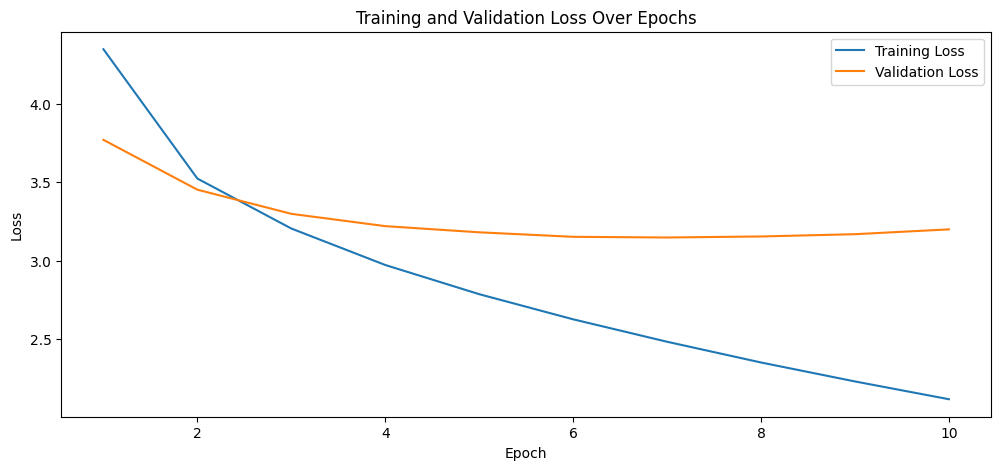

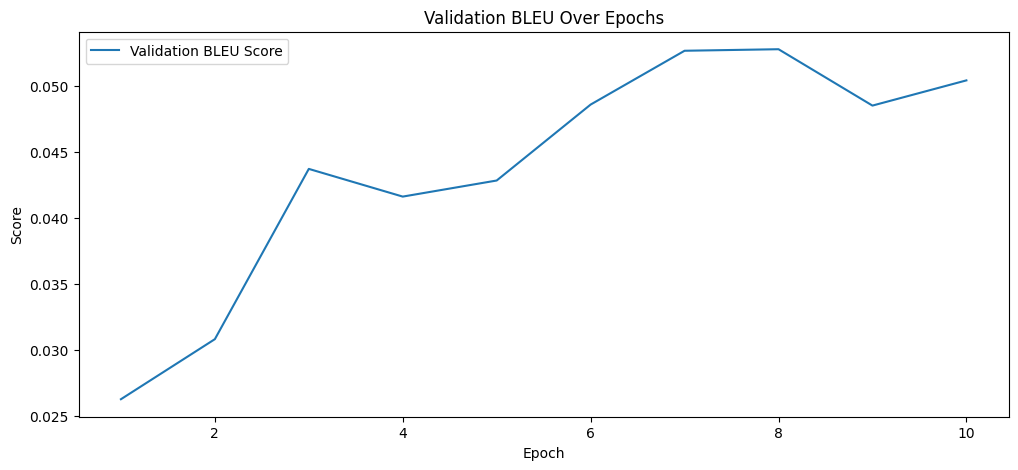

In [275]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.plot(epochs, metrics["train_losses"], label='Training Loss')
plt.plot(epochs, metrics["val_losses"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting BLEU 
plt.figure(figsize=(12, 5))
plt.plot(epochs, metrics["val_bleus"], label='Validation BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation BLEU Over Epochs')
plt.legend()
plt.show()


# Demo on The test set

In [264]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

In [265]:
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(28,28)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

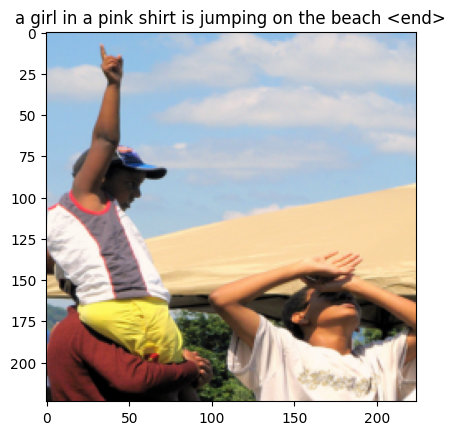

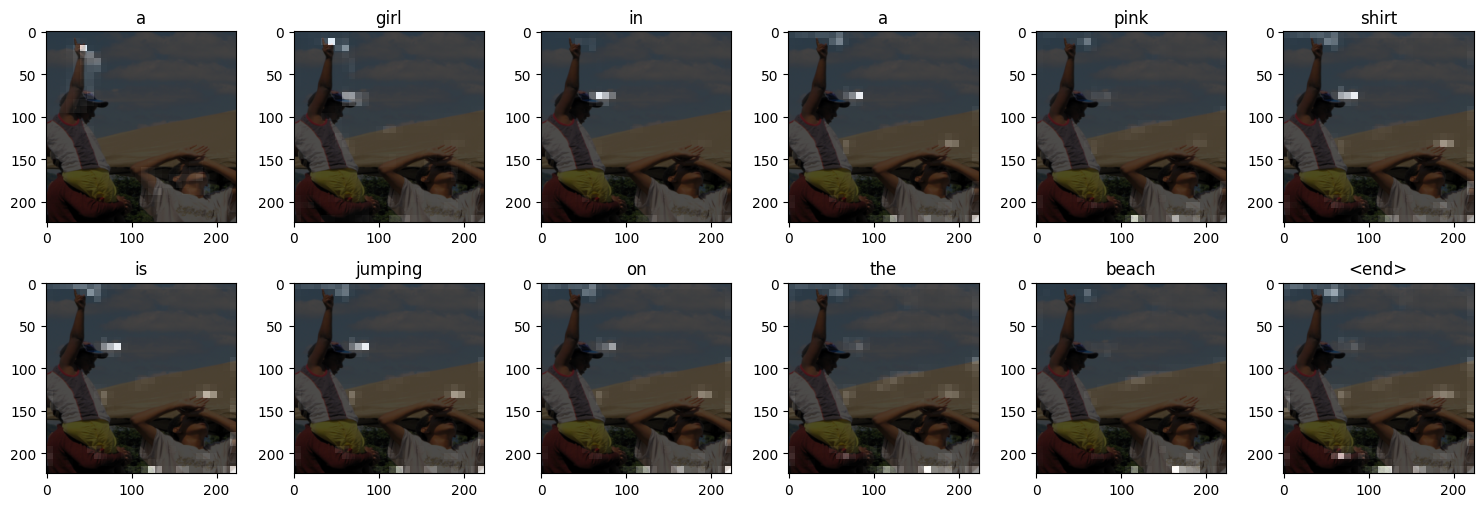

In [277]:
# Get a specific index from test dataset
idx = 5  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

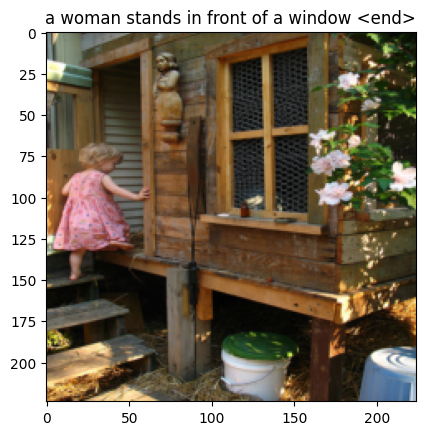

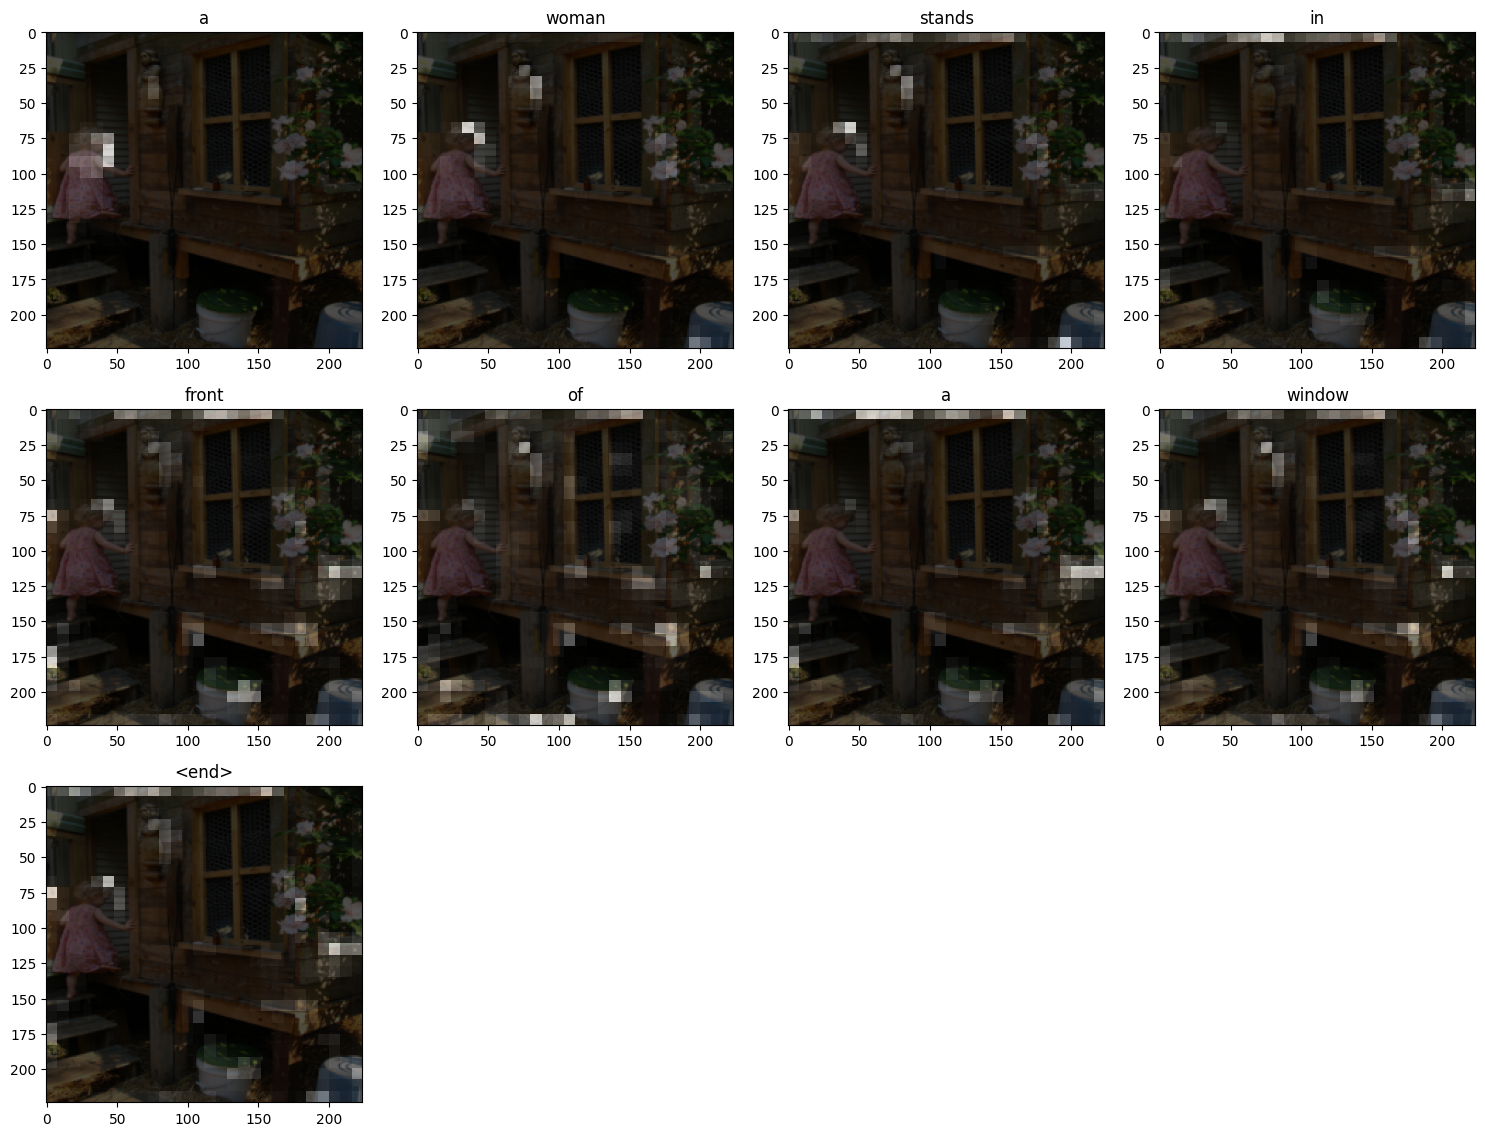

In [278]:
# Get a specific index from test dataset
idx = 100  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

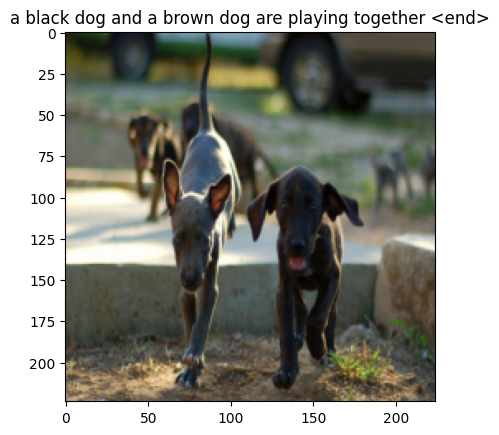

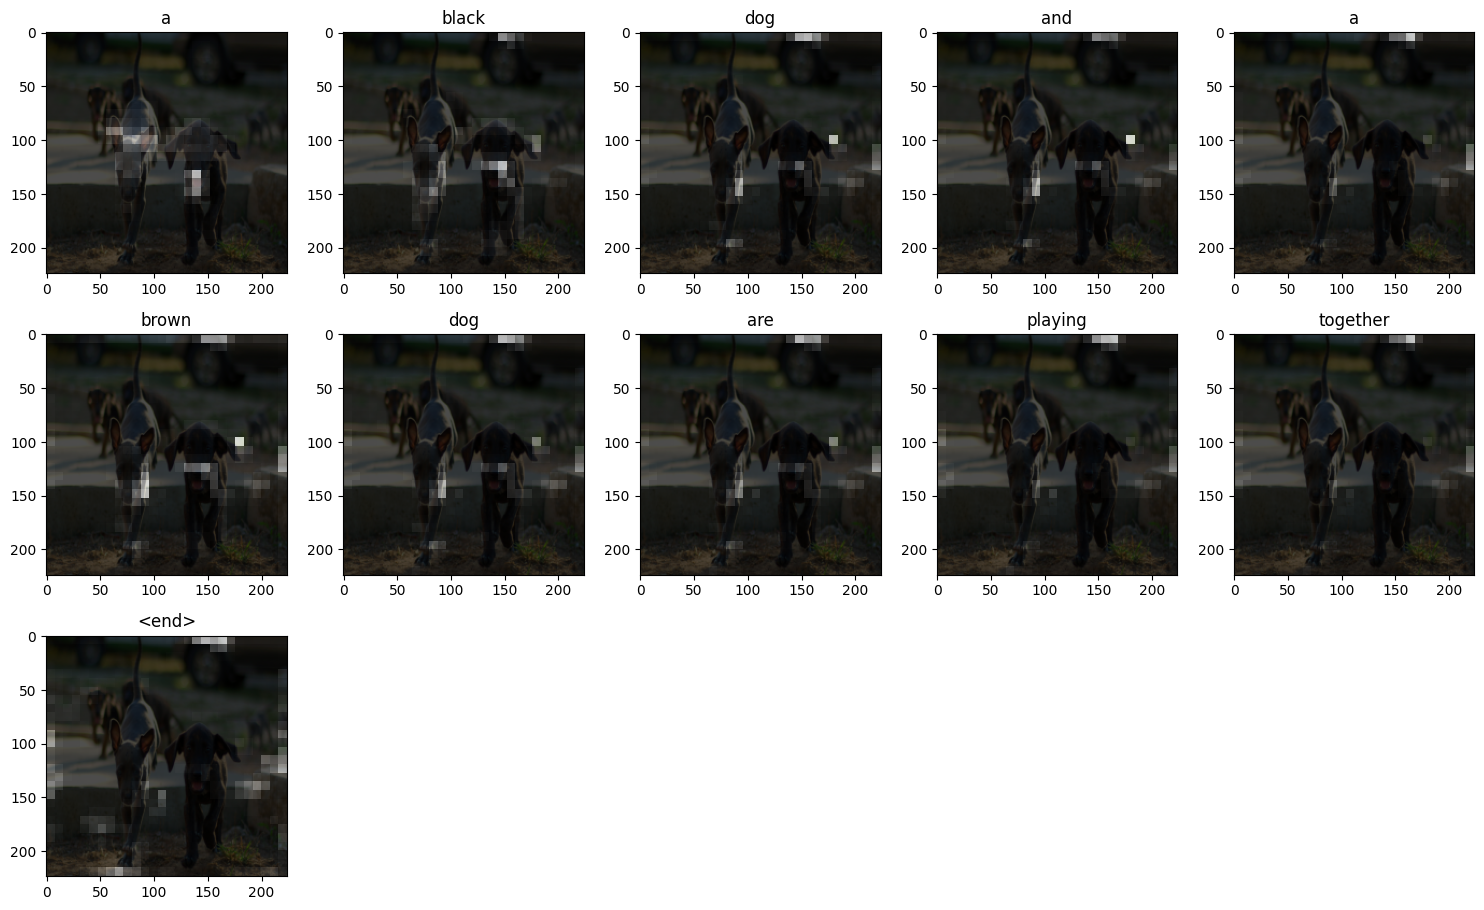

In [279]:
# Get a specific index from test dataset
idx = 145  # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

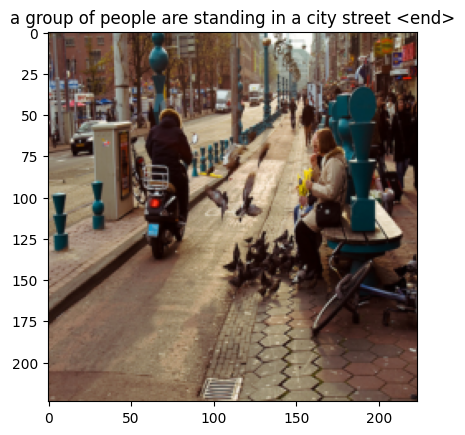

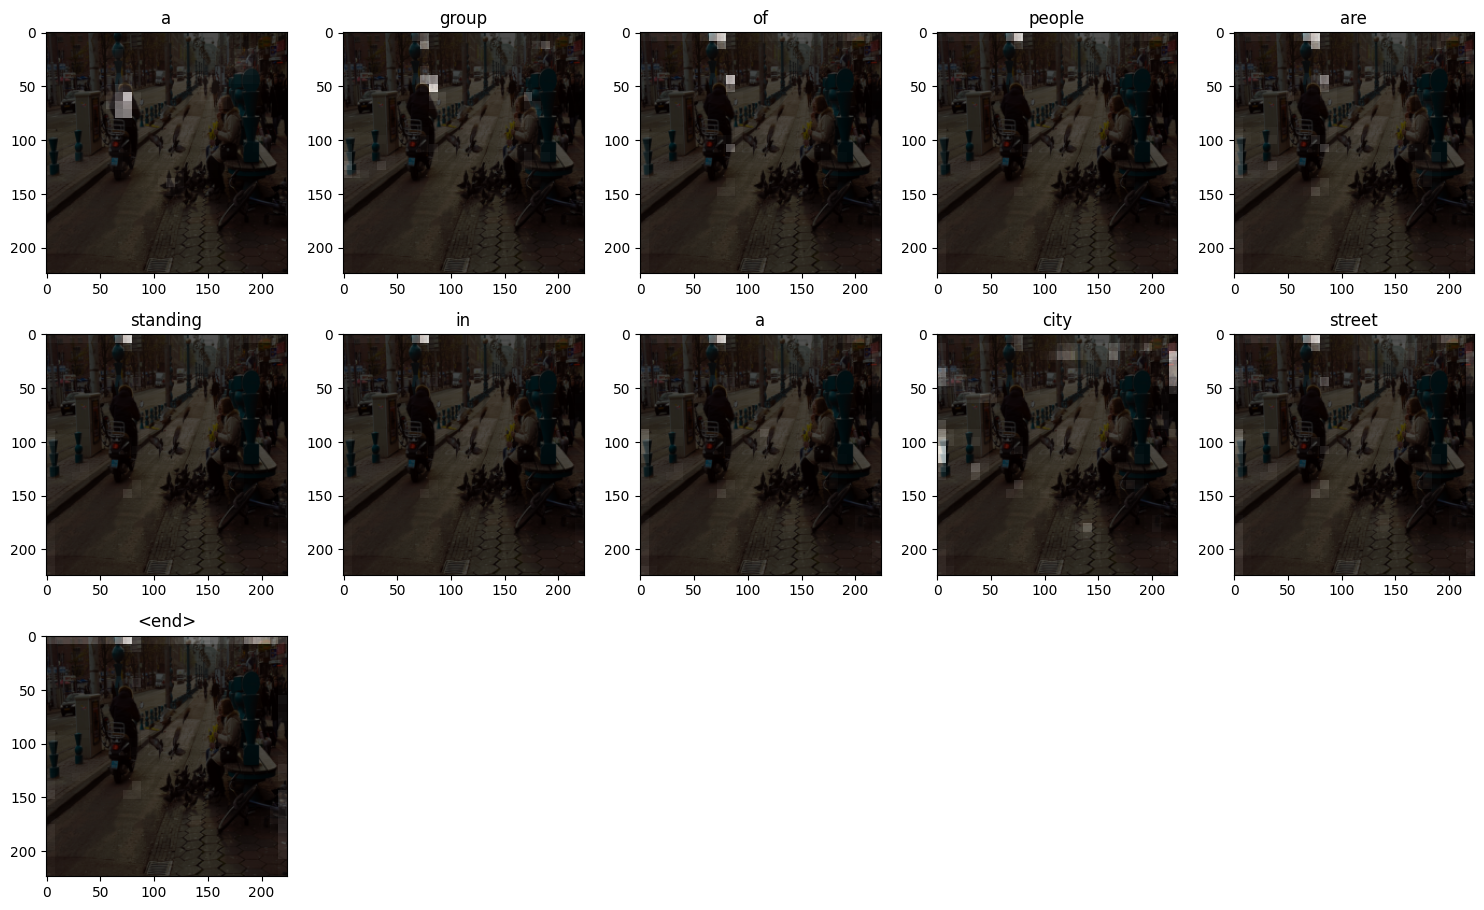

In [282]:
# Get a specific index from test dataset
idx = 212 # or any index you want to visualize
image, _ = test_dataset[idx]  # Access directly from dataset instead of loader

# Clone the image for both caption generation and plotting
img = image.detach().clone()
img1 = image.detach().clone()

# Generate caption (need to add batch dimension since model expects batched input)
caps, alphas = get_caps_from(img.unsqueeze(0))
plot_attention(img1, caps, alphas)

# Bleu score on Test dataset

In [284]:
def calculate_test_bleu():
    model.eval()  # Set to evaluation mode
    actual_captions = []
    predicted_captions = []
    smoothie = SmoothingFunction().method1
    
    with torch.no_grad():
        for test_images, test_captions, _ in test_loader:
            test_images = test_images.to(device)
            
            # Generate captions for BLEU score calculation
            features = model.module.encoder(test_images) if hasattr(model, 'module') else model.encoder(test_images)
            
            for i in range(test_images.size(0)):
                # Get actual caption (excluding special tokens)
                current_caption = test_captions[i].cpu().numpy().tolist()
                actual = [[idx2word[word] for word in current_caption if word != word2idx['<start>'] 
                          and word != word2idx['<end>'] and word != word2idx['<pad>']]]
                actual_captions.append(actual)
                
                # Generate predicted caption
                if hasattr(model, 'module'):
                    caps, _ = model.module.decoder.generate_caption(features[i:i+1])
                else:
                    caps, _ = model.decoder.generate_caption(features[i:i+1])
                predicted_captions.append(caps[:-1])  # exclude end token
    
    # Calculate BLEU score
    bleu_score = corpus_bleu(actual_captions, predicted_captions, smoothing_function=smoothie)
    
    print(f"Test BLEU Score: {bleu_score:.4f}")
    return bleu_score

# Calculate BLEU score on test set
test_bleu = calculate_test_bleu()

Test BLEU Score: 0.0503
